[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/azad-academy/denoising-diffusion-model/blob/main/diffusion_model_demo.ipynb)

## Learning End-to-End Channel Coding with Diffusion Models
 
This notebook file is a framework to learn the E2E channel coding with a generated channel by using diffusion models. For diffusion models, we use two denoising algorithms, DDPM and DDIM. They are evaluated by the generative performance, sampling speed, and the E2E error probability of the channel codes trained with them. 
To train the E2E framework, we first train the channel generative model with Gaussian signals as channel input. And then, the encoder and decoder models are trained with a fake channel sampled by the generative model. 



In [1]:
# Set the path
GDRIVE_MOUNT = False # In case you use Google Colab with G-Drive
PLOT_FIGURES = True 

if GDRIVE_MOUNT: 
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    path = '/content/drive/MyDrive/Colab Notebooks' # The path to the source codes
else: 
    path = !pwd
    path = path[0] # The path with the lbraries

import sys
sys.path.append(path+'/src')

# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
import pickle
import csv
from tqdm import tqdm
from utils import *
from utils_plot import *
import trainer as trainer

# Import modules from own libraries
import models
from channel_models import *
from ema import EMA

# Set the device 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Choose channel model and diffusion model type

In [2]:
channel_model_str = 'Rayleigh' #available options: AWGN, Rayleigh, SSPA
denoising_alg = 'DDPM' #available options: DDPM, DDIM


## Channel model settings

In [3]:
# Channel Model
M = 16
k = math.log2(M)
n = 7  # Block length
rate = k/n 


if channel_model_str == 'AWGN':
    channel_model = ch_AWGN
elif channel_model_str == 'Rayleigh':
    channel_model = ch_Rayleigh_AWGN
elif channel_model_str == 'SSPA':
    channel_model = ch_SSPA
else:
    raise Exception("Unrecognized channel model. Possible channel models: AWGN, Rayleigh, SSPA.")


## Deep Learning Settings - model parameters, training and testing hyperparameters, etc.

In [4]:
# Load and save models before and after training, respectively. 
LOADMODEL_gen = False
LOADMODEL_AE = False

SAVEMODEL_gen = False 
SAVEMODEL_AE = False

# Framework 
TRAINING_EbN0 = 12 # decibel
noise_std = EbNo_to_noise(TRAINING_EbN0, rate)

# Autoencoder (AE) Model (channel coding encoder & decoder)
### Models 
encoder = models.Encoder_1h(M, n, n).to(device)# _1h means taking one hot encoded messages. _n means normalizing the output.
decoder = models.Decoder_1h(M, n).to(device)
optimizer_AE = torch.optim.NAdam

# Diffusion Model
### Model Parameters
N_hl = 128 # Number of neurons in the hidden layer
num_steps = 100 # T
skip = 1 # Set this as 1 if DDPM. If DDIM, choose between 1 to T.
if denoising_alg == 'DDPM': 
    traj = range(0,num_steps)
elif denoising_alg == 'DDIM':
    traj = range(skip-1, num_steps, skip)


### Noise scheduling    
scheduling = 'cosine'
if scheduling == 'const':
# constant beta, no scheduling.
    betas = torch.tensor([5e-2] * num_steps).to(device) 
elif scheduling == 'cosine':
    # cosine scheduling
    betas = make_beta_schedule(schedule='cosine-zf', n_timesteps=num_steps).to(device) 
elif scheduling == 'sigmoid':
    # sigmoid scheduling
    betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=5e-3, end=5e-2).to(device) 
else:
    assert False, "Undefined scheduling method."
    
pred_type = 'v' # Available options: 'epsilon', v.

channel_gen = models.ConditionalModel_w_Condition(num_steps, 0, n, N_hl).to(device) # The condition includes the channel input.
optimizer_gen = optim.Adam
ema = EMA(0.9) # Create EMA model (Exponential Moving Average)
ema.register(channel_gen)

# Test Setting
ebn0_range = [*range(1,25+1)]
dataset_size_test = 1000000
batch_size_test = 100
max_epoch_test = 30


# File tag for saving and loading
file_tag = f'_{channel_model_str}_M{M}N{n}_{scheduling}'

model_tag_load_gen = file_tag +'.pt' 
model_tag_load_AE = file_tag +'.pt'
model_tag_save_gen = file_tag +'.pt'
model_tag_save_AE = file_tag +'.pt' 

path_state_dict = path + '/state_dict'

In [5]:
total_params_gen = sum(p.numel() for p in channel_gen.parameters() if p.requires_grad)
print('# of parameters (diffusion model): ' + str(total_params_gen))
total_params_enc = sum(p.numel() for p in encoder.parameters())
print('# of parameters (encoder): ' + str(total_params_enc))
total_params_dec = sum(p.numel() for p in decoder.parameters())
print('# of parameters (decoder): ' + str(total_params_dec))


# of parameters (diffusion model): 74247
# of parameters (encoder): 663
# of parameters (decoder): 672


## Defining variables and functions for diffusion models

In [6]:
# Calculating constants

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float().to(device), alphas_prod[:-1]], 0)
 
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [7]:
def q_x(x_0, t, noise=None):
    shape = x_0.shape
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, shape)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, shape)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

In [8]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    shape = x_0.shape
    coef_1 = extract(posterior_mean_coef_1, t, shape)
    coef_2 = extract(posterior_mean_coef_2, t, shape)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, shape)
    return mean, var

Diffusion process for message 1 in the first two dimensions.


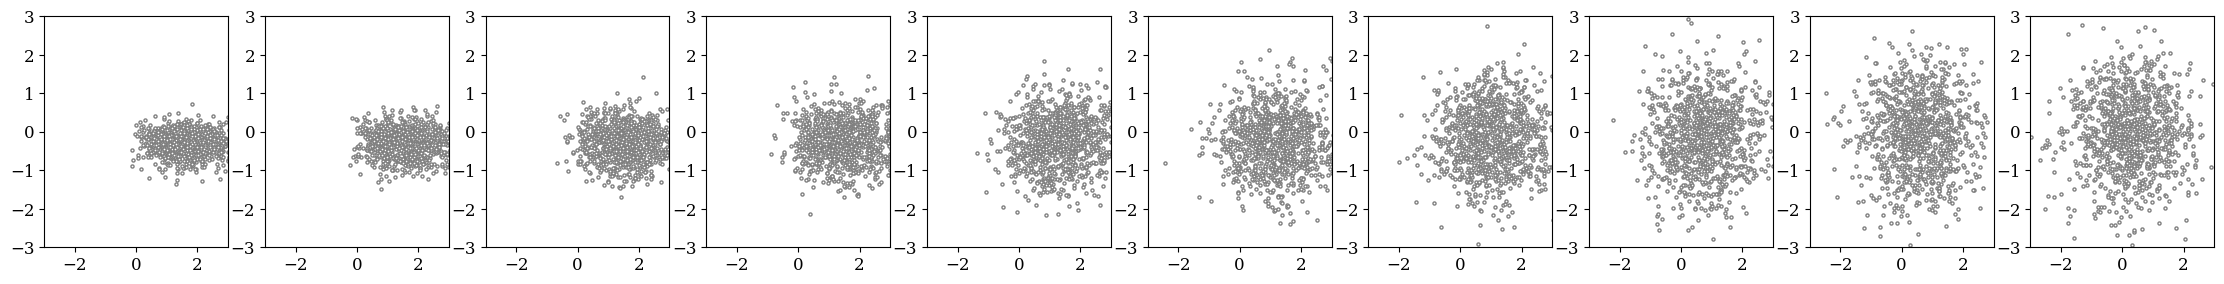

Adjust beta according to the diffusion results. If it needs to be more noisy, increase beta. If it gets noisy too soon, decrease beta.


In [9]:
# Checking diffusion process 

if PLOT_FIGURES:
    show_diffusion_m(channel_model, q_x, encoder, device, noise_std, M=M, m = 0,num_samples_df=1000
                     ,num_steps=num_steps, max_amp = 3)
 

# Training E2E framework

In [10]:
# Load pretrained diffusion model if necessary

load_class = LoadModels(path_state_dict, LOADMODEL_gen, channel_gen, model_tag_load_gen, LOADMODEL_AE, encoder
                        , decoder, model_tag_load_AE)

channel_gen, encoder, decoder = load_class.load() # It loads only the models whose LOADMODEL flag is True.


epoch 10: loss 4.55e-01: 100%|██████████████| 2000/2000 [00:27<00:00, 71.97it/s]


The denoising process is plotted for the message 1 and the first two dimensions.


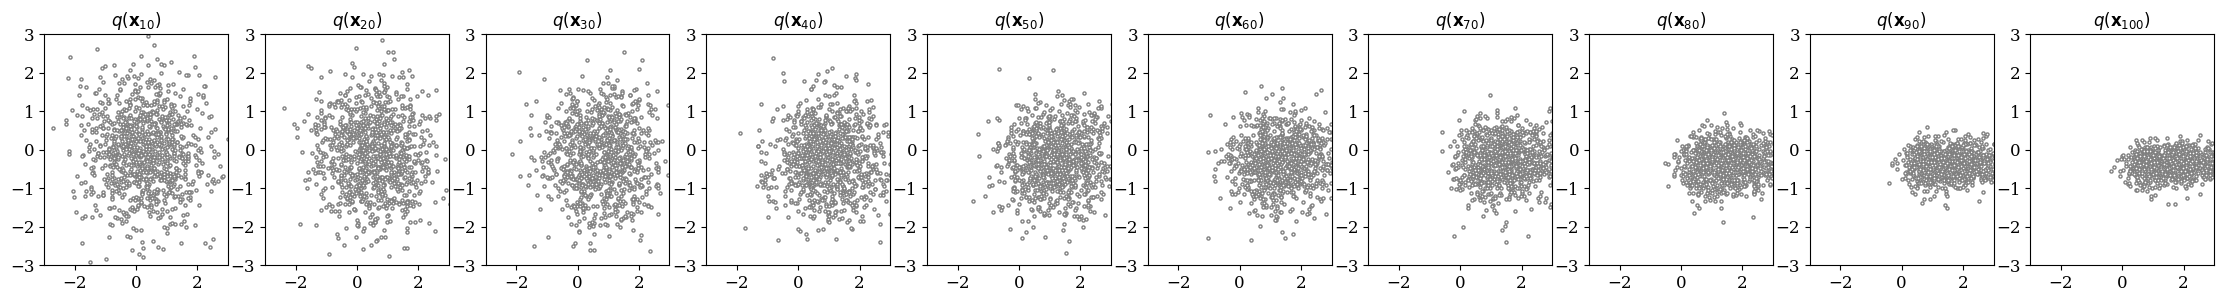

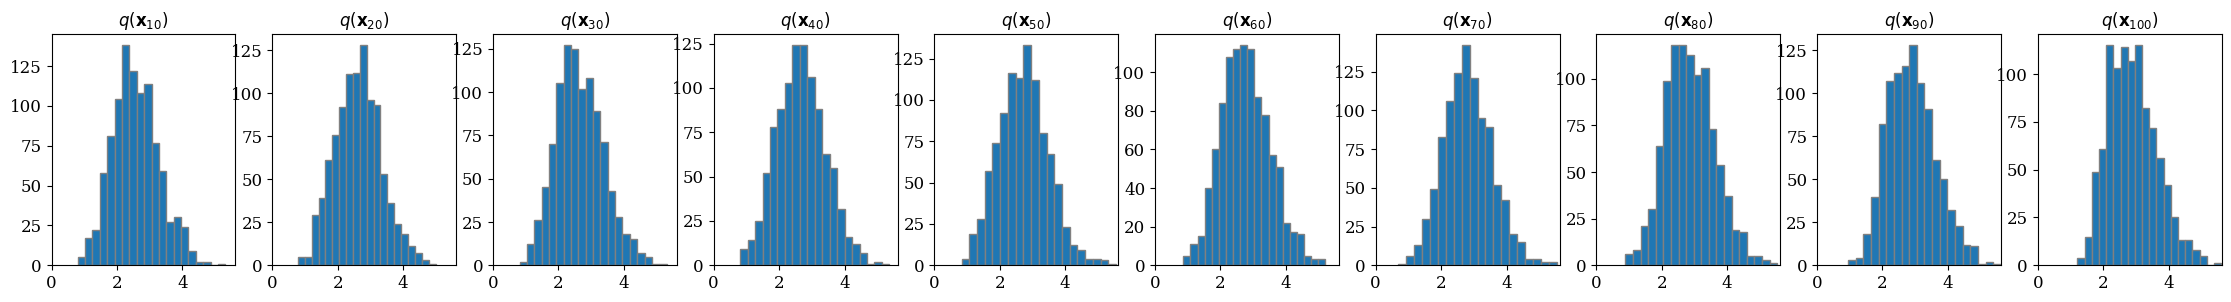

Training the generative model is completed.


In [11]:
# Training Phase 1: Learn the channel by training the diffusion model. 
# Freeze enc/dec pair and optimize the diffusion model.

## Training dataset: Gaussian channel input and channel output. 

dataset_size_gen = 10**7 
batch_size_gen = 5000
max_epoch_gen = 10 
lr_gen = 1e-3

tconf_gen = trainer.TrainerConfig_DDM(max_epochs = max_epoch_gen, dataset_size = dataset_size_gen
                                      , batch_size = batch_size_gen, noise_std = noise_std
                                      , learning_rate = lr_gen, M = M, n = n, rate = rate
                                      , num_steps = num_steps, betas = betas, optim_gen = optimizer_gen
                                      , pred_type = pred_type)

t_gen = trainer.Trainer_DDM(channel_gen, ema, device, channel_model, tconf_gen)
t_gen.train_PreT()


if PLOT_FIGURES :   
    show_denoising_m(channel_gen, encoder, device, alphas, betas, alphas_bar_sqrt, one_minus_alphas_bar_sqrt,
                     M =M, m = 0, num_samples_dn = 1000, num_steps = num_steps,max_amp=3,
                     PreT=True, denoising_alg = denoising_alg, traj = traj, pred_type=pred_type) 

print('Training the generative model is completed.')   


epoch 20: loss 4.69e-01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 70.96it/s]


The denoising process is plotted for the message 1 and the first two dimensions.


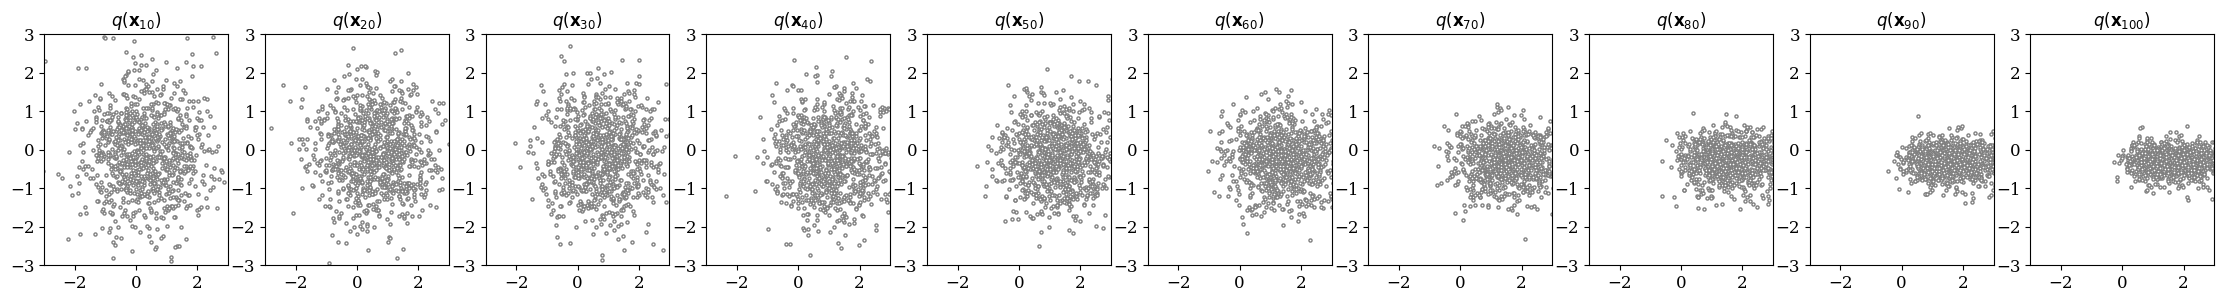

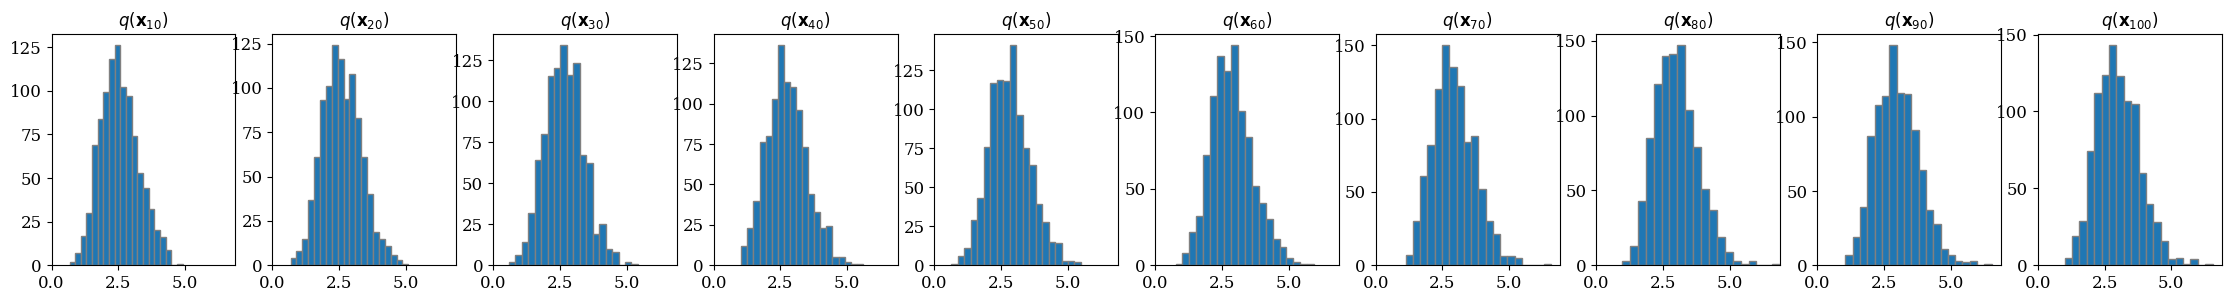

Training the generative model is completed.


In [13]:
# Training Phase 1: Learn the channel by training the diffusion model. 
# Freeze enc/dec pair and optimize the diffusion model.

## Training dataset: Gaussian channel input and channel output. 

dataset_size_gen = 10**7 
batch_size_gen = 5000
max_epoch_gen = 20 
lr_gen = 1e-4

tconf_gen = trainer.TrainerConfig_DDM(max_epochs = max_epoch_gen, dataset_size = dataset_size_gen
                                      , batch_size = batch_size_gen, noise_std = noise_std
                                      , learning_rate = lr_gen, M = M, n = n, rate = rate
                                      , num_steps = num_steps, betas = betas, optim_gen = optimizer_gen
                                      , pred_type = pred_type)

t_gen = trainer.Trainer_DDM(channel_gen, ema, device, channel_model, tconf_gen)
t_gen.train_PreT()


if PLOT_FIGURES :   
    show_denoising_m(channel_gen, encoder, device, alphas, betas, alphas_bar_sqrt, one_minus_alphas_bar_sqrt,
                     M =M, m = 0, num_samples_dn = 1000, num_steps = num_steps,max_amp=3,
                     PreT=True, denoising_alg = denoising_alg, traj = traj, pred_type=pred_type) 

print('Training the generative model is completed.')   


In [ ]:
# Save the diffusion model if necessary
model_tag_load_gen = file_tag +'.pt' 
model_tag_load_AE = file_tag +'.pt' 
model_tag_save_gen = file_tag +'.pt'
model_tag_save_AE = file_tag +'.pt' 

path_state_dict = path + '/state_dict'

SAVEMODEL_gen = True
SAVEMODEL_AE = False
save_class = SaveModels(path_state_dict, SAVEMODEL_gen, channel_gen, model_tag_save_gen, SAVEMODEL_AE, encoder
                        , decoder, model_tag_save_AE)
save_class.model_gen = channel_gen
save_class.save_gen()

# Check the diffusion models by figures

The evaluation of generated channel in comparison to the original source; m = 3


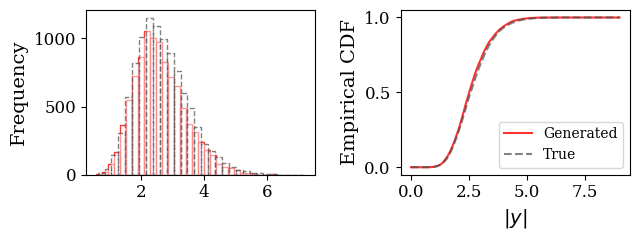

In [15]:
denoising_alg = 'DDIM'
skip = 5
traj = range(skip-1, num_steps, skip)

if PLOT_FIGURES:
    ECDF_histogram_m(encoder, channel_gen, channel_model_str, device, alphas, betas, alphas_bar_sqrt
                     , one_minus_alphas_bar_sqrt
                     , num_steps, M, 10000,1000, noise_std,max_amp=9, m=2, PreT=True
                     , denoising_alg = denoising_alg, traj = traj, pred_type=pred_type)


The scatter plot of the generated data in comparison to the original source; message 3


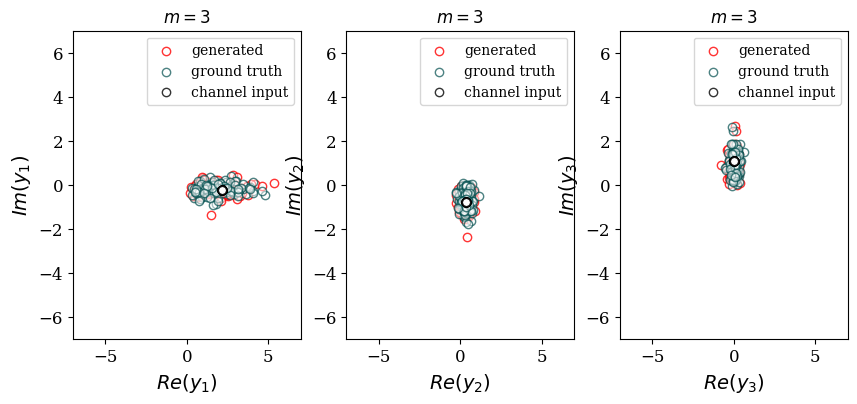

In [16]:
#denoising_alg = 'DDIM' 
#skip = 1 
#traj = range(skip-1, num_steps, skip) # starting from 0 ending with (num_steps-1)

if PLOT_FIGURES:
    Constellation_InOut_m(encoder, channel_gen, channel_model_str, device, alphas, betas, alphas_bar_sqrt
                          , one_minus_alphas_bar_sqrt
                          , num_steps, M, 100, noise_std, m=2, max_amp=7, PreT=True
                          , denoising_alg = denoising_alg
                          , traj = traj, pred_type=pred_type)


The denoising process is plotted for the message 1 and the first two dimensions.


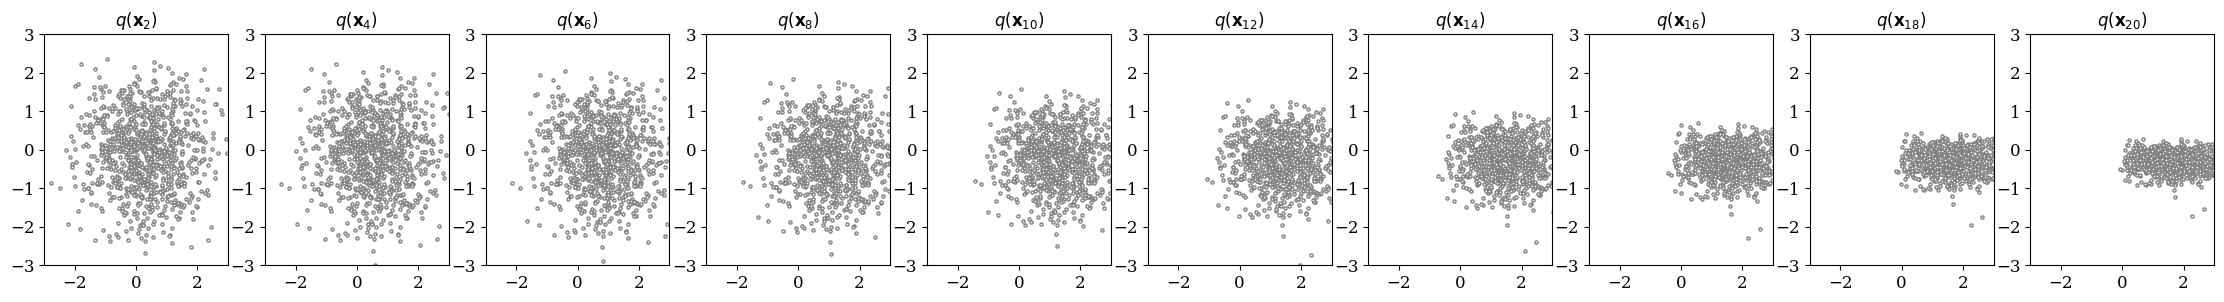

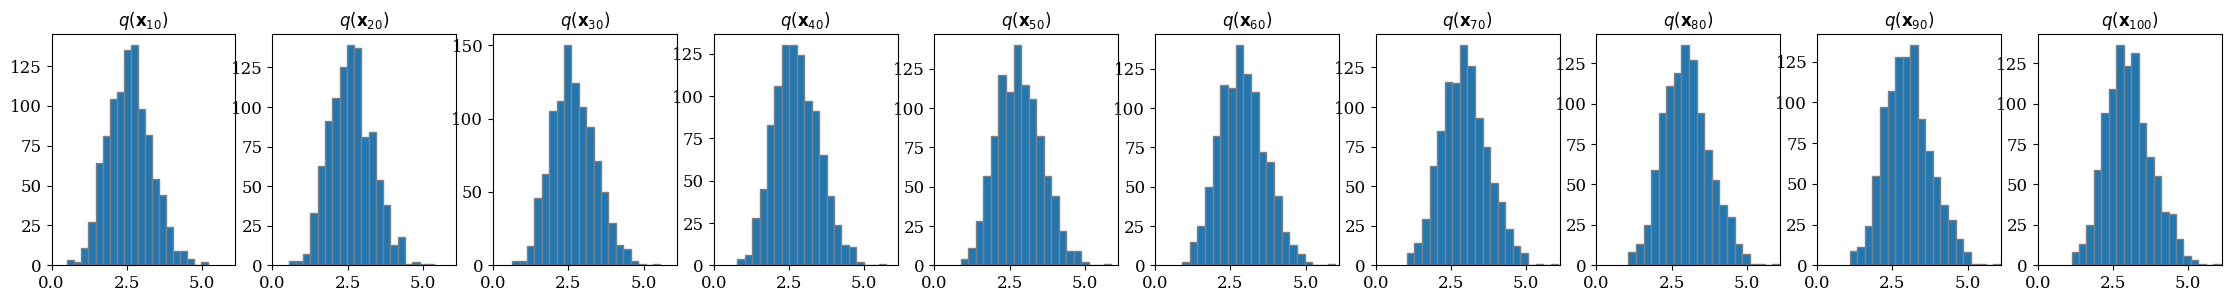

In [17]:
show_denoising_m(channel_gen, encoder, device, alphas, betas, alphas_bar_sqrt
                 , one_minus_alphas_bar_sqrt, M = M
                 , m = 0, num_samples_dn = 1000, num_steps = num_steps,max_amp=3, PreT=True
                 , denoising_alg = denoising_alg, traj = traj, pred_type=pred_type) 


# Train AEs with different sampling algorithms

In [18]:
# Training Phase 2: train the AE with generated channel outputs. 
# Freeze the diffusion model and optimize the AE.

## Training dataset: uniformly distributed messages, encoded codewords, channel outputs of those codewords.

SAVEMODEL_gen = False
SAVEMODEL_AE = True

lr_AE = 1e-3 # learning rate of the encoder/decoder.
dataset_size_AE = 1000000
batch_size_AE = 100
max_epoch_AE = 10

denoising_alg = 'DDIM'
skip = 5
traj = range(skip-1, num_steps, skip)

#encoder = models.Encoder_1h(M, n, n).to(device) # _1h means taking one hot encoded messages.
#decoder = models.Decoder_1h(M, n).to(device)

dataset_AE = np.random.randint(M, size=dataset_size_AE)
tconf_AE = trainer.TrainerConfig_AE_w_DDM(max_epochs = max_epoch_AE, dataset_size = dataset_size_AE
                                          , batch_size = batch_size_AE, noise_std = noise_std
                                          , learning_rate = lr_AE, M = M, n=n, rate = rate
                                          , num_steps = num_steps, traj = traj, denoising_alg = denoising_alg
                                          , optim_AE = optimizer_AE, betas=betas, channel_model = channel_model
                                          , pred_type = pred_type)
t_AE = trainer.Trainer_AE_w_DDM(encoder, decoder, channel_gen, device, tconf_AE)
t_AE.train_PreT()


print('Training the AE model is completed.')
t_AE.test(channel_model)



epoch 10: loss 4.27e-03 SER 1.44e-03: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:47<00:00, 34.78it/s]


Training the AE model is completed.


Validation SER 4.63e-03: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1490.37it/s]


0.004635999896377325

In [22]:
# Training Phase 2: train the AE with generated channel outputs. 
# Freeze the diffusion model and optimize the AE.

## Training dataset: uniformly distributed messages, encoded codewords, channel outputs of those codewords.

SAVEMODEL_gen = False
SAVEMODEL_AE = True

lr_AE = 1e-3 # learning rate of the encoder/decoder.
dataset_size_AE = 1000000
batch_size_AE = 100
max_epoch_AE = 10


dataset_AE = np.random.randint(M, size=dataset_size_AE)
tconf_AE = trainer.TrainerConfig_AE_w_DDM(max_epochs = max_epoch_AE, dataset_size = dataset_size_AE
                                          , batch_size = batch_size_AE, noise_std = noise_std
                                          , learning_rate = lr_AE, M = M, n=n, rate = rate
                                          , num_steps = num_steps, traj = traj, denoising_alg = denoising_alg
                                          , optim_AE = optimizer_AE, betas=betas, channel_model = channel_model
                                          , pred_type = pred_type)
t_AE = trainer.Trainer_AE_w_DDM(encoder, decoder, channel_gen, device, tconf_AE)
t_AE.train_PreT()


print('Training the AE model is completed.')
t_AE.test(channel_model)


if denoising_alg == 'DDPM:
    file_tag_tmp = file_tag + '_' + denoising_alg
elif denoising_alg == 'DDIM':
    file_tag_tmp = file_tag + '_' + denoising_alg + str(skip)
model_tag_save_AE = file_tag_tmp +'.pt' 

save_class = SaveModels(path_state_dict, SAVEMODEL_gen, channel_gen, model_tag_save_gen, SAVEMODEL_AE, encoder
                        , decoder, model_tag_save_AE)
save_class.save_AE()



epoch 10: loss 3.50e-03 SER 1.20e-03: 100%|██████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:47<00:00, 34.75it/s]


Training the AE model is completed.


Validation SER 3.92e-03: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1485.84it/s]


# Test AEs


In [23]:
# Test the AE

labels = torch.randint(low=0, high=M, size=[dataset_size_test])
tconf = trainer.TrainerConfig(max_epochs=max_epoch_test, noise_std = noise_std, batch_size=batch_size_test
                              , M=M, rate=rate, pred_type=pred_type)

# Load the encoder and decoder if necessary
#file_tag_tmp = file_tag + denoising_alg + str(skip)
#model_tag_load_AE = file_tag_tmp +'.pt'
#LOADMODEL_AE = True
#load_class = LoadModels(path_state_dict, SAVEMODEL_gen, channel_gen
#                        , model_tag_save_gen, SAVEMODEL_AE, encoder
#                        , decoder, model_tag_save_AE)
#_, encoder, decoder = load_class.load() # It loads only the models whose LOADMODEL flag is True.


if channel_model_str == 'AWGN':
    channel_diff_test = models.Channel(encoder, decoder).to(device)
if channel_model_str == 'Rayleigh':
    channel_diff_test = models.Channel_ray(encoder, decoder).to(device)
if channel_model_str == 'SSPA':
    channel_diff_test = models.Channel_SSPA_n(encoder, decoder).to(device)
    
t_diff = trainer.Trainer(channel_diff_test, labels, tconf, one_hot=True)
SER = t_diff.test(snr_range=ebn0_range, one_hot=True, erasure_bound=0.7) 
        

SNR 16  iter 9900: SER 4.515e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 17  iter 9900: SER 2.990e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.88it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 17  iter 9900: SER 3.040e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 18  iter 9900: SER 1.363e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 18  iter 9900: SER 1.525e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1120.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 18  iter 9900: SER 1.687e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 18  iter 9900: SER 1.596e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 18  iter 9900: SER 1.737e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1109.64it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 19  iter 9900: SER 1.131e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 19  iter 9900: SER 1.081e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.45it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 19  iter 9900: SER 1.040e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 19  iter 9900: SER 1.121e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 19  iter 9900: SER 1.131e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 19  iter 9900: SER 1.121e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 19  iter 9900: SER 9.797e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.64it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 19  iter 9900: SER 1.182e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 20  iter 9900: SER 6.666e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 20  iter 9900: SER 7.474e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1120.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 20  iter 9900: SER 6.868e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 20  iter 9900: SER 8.585e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1117.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 20  iter 9900: SER 7.474e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 20  iter 9900: SER 6.565e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.76it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 20  iter 9900: SER 6.060e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 20  iter 9900: SER 6.868e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 20  iter 9900: SER 6.363e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 20  iter 9900: SER 5.454e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 20  iter 9900: SER 6.666e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 20  iter 9900: SER 7.272e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 20  iter 9900: SER 7.373e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 21  iter 9900: SER 5.454e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 21  iter 9900: SER 4.040e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 21  iter 9900: SER 4.242e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 21  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 21  iter 9900: SER 4.040e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 21  iter 9900: SER 3.232e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 21  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 21  iter 9900: SER 3.737e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.44it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 21  iter 9900: SER 4.848e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.76it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 21  iter 9900: SER 4.141e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 21  iter 9900: SER 3.737e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 21  iter 9900: SER 4.141e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.59it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 21  iter 9900: SER 4.141e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 21  iter 9900: SER 5.151e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 21  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1108.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 21  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1080.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 21  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1116.55it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 21  iter 9900: SER 4.949e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 21  iter 9900: SER 4.646e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.44it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 21  iter 9900: SER 3.737e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 21  iter 9900: SER 4.949e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 22  iter 9900: SER 2.828e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 22  iter 9900: SER 3.636e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.33it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 22  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 22  iter 9900: SER 2.828e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 22  iter 9900: SER 3.030e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1115.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 22  iter 9900: SER 3.131e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 22  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 22  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 22  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 22  iter 9900: SER 3.333e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 22  iter 9900: SER 2.929e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 22  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1147.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 22  iter 9900: SER 3.131e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 22  iter 9900: SER 3.636e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 22  iter 9900: SER 3.838e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1147.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 22  iter 9900: SER 3.030e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 22  iter 9900: SER 3.131e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 22  iter 9900: SER 3.939e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 22  iter 9900: SER 3.030e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1151.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 22  iter 9900: SER 2.828e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1149.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 22  iter 9900: SER 3.434e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1150.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 22  iter 9900: SER 3.232e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.72it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 22  iter 9900: SER 2.828e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 22  iter 9900: SER 3.939e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 22  iter 9900: SER 4.747e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 22  iter 9900: SER 3.535e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 22  iter 9900: SER 3.838e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.48it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 22  iter 9900: SER 3.737e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 22  iter 9900: SER 3.838e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 23  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1124.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 23  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 23  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 23  iter 9900: SER 3.333e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 23  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 23  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 23  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 23  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 23  iter 9900: SER 2.222e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 23  iter 9900: SER 2.626e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 23  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 23  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 23  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1146.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 23  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 23  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 23  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 23  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 23  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 23  iter 9900: SER 2.222e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 23  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 23  iter 9900: SER 3.131e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 23  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 23  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 23  iter 9900: SER 3.232e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1122.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 23  iter 9900: SER 2.222e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 23  iter 9900: SER 3.333e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 23  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 23  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 23  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 23  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1118.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  31000000


SNR 23  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  32000000


SNR 23  iter 9900: SER 2.626e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  33000000


SNR 23  iter 9900: SER 3.333e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  34000000


SNR 23  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  35000000


SNR 23  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  36000000


SNR 23  iter 9900: SER 2.828e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  37000000


SNR 23  iter 9900: SER 3.333e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  38000000


SNR 23  iter 9900: SER 2.929e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  39000000


SNR 23  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 23  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  41000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1120.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 24  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 24  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 24  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 24  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 24  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 24  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 24  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 24  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1108.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 24  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 24  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 24  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.14it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 24  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.51it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 24  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.49it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 24  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 24  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.44it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 24  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 24  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 24  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 24  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 24  iter 9900: SER 2.222e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1137.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 24  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  31000000


SNR 24  iter 9900: SER 2.222e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1122.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  32000000


SNR 24  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  33000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  34000000


SNR 24  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1124.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  35000000


SNR 24  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.03it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  36000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.50it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  37000000


SNR 24  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  38000000


SNR 24  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  39000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1120.44it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 24  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  41000000


SNR 24  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1118.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  42000000


SNR 24  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  43000000


SNR 24  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  44000000


SNR 24  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1109.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  45000000


SNR 24  iter 9900: SER 3.030e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  46000000


SNR 24  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  47000000


SNR 24  iter 9900: SER 2.727e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  48000000


SNR 24  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  49000000


SNR 24  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  51000000


SNR 24  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1121.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  52000000


SNR 24  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1124.88it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  53000000


SNR 24  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  54000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 25  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.81it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 25  iter 9900: SER 9.090e-06: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 25  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 25  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1144.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.99it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.76it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 25  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1093.57it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 25  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.94it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 25  iter 9900: SER 8.080e-06: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1110.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 25  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 25  iter 9900: SER 2.525e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.22it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  21000000


SNR 25  iter 9900: SER 7.070e-06: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  22000000


SNR 25  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1131.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  23000000


SNR 25  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1126.85it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  24000000


SNR 25  iter 9900: SER 7.070e-06: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  25000000


SNR 25  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  26000000


SNR 25  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  27000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  28000000


SNR 25  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1124.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  29000000


SNR 25  iter 9900: SER 1.212e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.68it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  31000000


SNR 25  iter 9900: SER 2.323e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1121.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  32000000


SNR 25  iter 9900: SER 1.919e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  33000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  34000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.07it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  35000000


SNR 25  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  36000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1145.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  37000000


SNR 25  iter 9900: SER 2.020e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  38000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  39000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1121.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1116.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  41000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.10it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  42000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1142.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  43000000


SNR 25  iter 9900: SER 1.818e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  44000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  45000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.42it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  46000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  47000000


SNR 25  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.32it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  48000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  49000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1111.06it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 25  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  51000000


SNR 25  iter 9900: SER 1.616e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.78it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  52000000


SNR 25  iter 9900: SER 1.111e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  53000000


SNR 25  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1143.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  54000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  55000000


SNR 25  iter 9900: SER 2.424e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.14it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  56000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1141.87it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  57000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1116.80it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  58000000


SNR 25  iter 9900: SER 2.121e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1138.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  59000000


SNR 25  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 25  iter 9900: SER 1.414e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  61000000


SNR 25  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1126.37it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  62000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.77it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  63000000


SNR 25  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.41it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  64000000


SNR 25  iter 9900: SER 1.717e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1129.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  65000000


SNR 25  iter 9900: SER 1.515e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1139.08it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  66000000


SNR 25  iter 9900: SER 1.313e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.68it/s]


In [19]:
# Test the AE

labels = torch.randint(low=0, high=M, size=[dataset_size_test])
tconf = trainer.TrainerConfig(max_epochs=max_epoch_test, noise_std = noise_std, batch_size=batch_size_test
                              , M=M, rate=rate, pred_type=pred_type)

# Load the encoder and decoder if necessary
#file_tag_tmp = file_tag + denoising_alg + str(skip)
#model_tag_load_AE = file_tag_tmp +'.pt'
#LOADMODEL_AE = True
#load_class = LoadModels(path_state_dict, SAVEMODEL_gen, channel_gen
#                        , model_tag_save_gen, SAVEMODEL_AE, encoder
#                        , decoder, model_tag_save_AE)
#_, encoder, decoder = load_class.load() # It loads only the models whose LOADMODEL flag is True.


if channel_model_str == 'AWGN':
    channel_diff_test = models.Channel(encoder, decoder).to(device)
if channel_model_str == 'Rayleigh':
    channel_diff_test = models.Channel_ray(encoder, decoder).to(device)
if channel_model_str == 'SSPA':
    channel_diff_test = models.Channel_SSPA_n(encoder, decoder).to(device)
    
t_diff = trainer.Trainer(channel_diff_test, labels, tconf, one_hot=True)
SER = t_diff.test(snr_range=ebn0_range, one_hot=True, erasure_bound=0.7) 
        

SNR 17  iter 9900: SER 4.545e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 18  iter 9900: SER 2.848e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 18  iter 9900: SER 3.040e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1110.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 19  iter 9900: SER 2.040e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1119.15it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 19  iter 9900: SER 1.848e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1127.87it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 19  iter 9900: SER 2.040e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 19  iter 9900: SER 1.838e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1123.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 20  iter 9900: SER 1.353e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 20  iter 9900: SER 1.454e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1135.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 20  iter 9900: SER 1.464e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1118.89it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 20  iter 9900: SER 1.525e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1121.96it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 20  iter 9900: SER 1.485e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 21  iter 9900: SER 1.232e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 21  iter 9900: SER 1.101e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.39it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 21  iter 9900: SER 9.797e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1116.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 21  iter 9900: SER 1.131e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 21  iter 9900: SER 8.787e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1132.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 21  iter 9900: SER 1.010e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 21  iter 9900: SER 8.989e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 21  iter 9900: SER 1.141e-04: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 22  iter 9900: SER 9.999e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1136.20it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 22  iter 9900: SER 9.797e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1133.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 22  iter 9900: SER 9.898e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1130.42it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 22  iter 9900: SER 7.777e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1115.28it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 22  iter 9900: SER 8.888e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1119.95it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 22  iter 9900: SER 7.777e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 22  iter 9900: SER 6.969e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 22  iter 9900: SER 7.373e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1152.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 22  iter 9900: SER 8.383e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 22  iter 9900: SER 9.494e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 23  iter 9900: SER 7.272e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.36it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 23  iter 9900: SER 5.353e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 23  iter 9900: SER 6.060e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.53it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 23  iter 9900: SER 7.070e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 23  iter 9900: SER 6.868e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1151.00it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 23  iter 9900: SER 6.666e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1134.61it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 23  iter 9900: SER 7.575e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.42it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 23  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1155.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 23  iter 9900: SER 8.080e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.34it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 23  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 23  iter 9900: SER 7.171e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1160.31it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 23  iter 9900: SER 5.353e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1148.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 23  iter 9900: SER 7.373e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 23  iter 9900: SER 6.060e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.92it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 24  iter 9900: SER 5.959e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 24  iter 9900: SER 5.050e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 24  iter 9900: SER 6.161e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 24  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 24  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.09it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 24  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.91it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 24  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1160.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 24  iter 9900: SER 6.868e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1155.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 24  iter 9900: SER 6.969e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 24  iter 9900: SER 5.555e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 24  iter 9900: SER 4.949e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.26it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 24  iter 9900: SER 6.060e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1140.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 24  iter 9900: SER 5.050e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1125.83it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 24  iter 9900: SER 7.171e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1150.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 24  iter 9900: SER 6.868e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1152.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 24  iter 9900: SER 6.161e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.35it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 25  iter 9900: SER 4.646e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.40it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  2000000


SNR 25  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  3000000


SNR 25  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1162.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  4000000


SNR 25  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.54it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  5000000


SNR 25  iter 9900: SER 4.848e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  6000000


SNR 25  iter 9900: SER 5.252e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1158.17it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  7000000


SNR 25  iter 9900: SER 5.050e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1155.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  8000000


SNR 25  iter 9900: SER 4.747e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  9000000


SNR 25  iter 9900: SER 3.636e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1156.47it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  10000000


SNR 25  iter 9900: SER 4.242e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1153.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  11000000


SNR 25  iter 9900: SER 4.444e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1153.46it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  12000000


SNR 25  iter 9900: SER 3.434e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1150.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  13000000


SNR 25  iter 9900: SER 4.141e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.86it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  14000000


SNR 25  iter 9900: SER 4.242e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1154.67it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  15000000


SNR 25  iter 9900: SER 5.353e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  16000000


SNR 25  iter 9900: SER 4.040e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1161.11it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  17000000


SNR 25  iter 9900: SER 6.262e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1162.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  18000000


SNR 25  iter 9900: SER 5.757e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1163.02it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  19000000


SNR 25  iter 9900: SER 5.353e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1157.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 25  iter 9900: SER 5.353e-05: 100%|████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1159.02it/s]


# Plot figures 

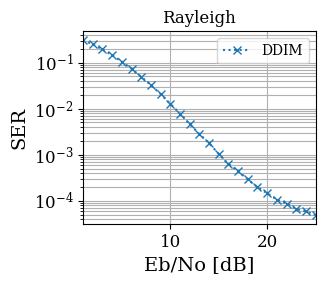

In [20]:
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
unfilled_markers = [m for m, func in Line2D.markers.items()
                    if func != 'nothing' and m not in Line2D.filled_markers]

linestyles = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted', 'dashed', 'dashdot']

if PLOT_FIGURES:
    fig = plt.figure(figsize=(3, 2.5))
    # Plot Autoencoder
    plt.semilogy(ebn0_range, SER, 'x:', label = denoising_alg)
    plt.gca().set_xlim(ebn0_range[0], ebn0_range[-1])
    plt.ylabel("SER", rotation=90)
    plt.xlabel("Eb/No [dB]")
    plt.title(channel_model_str)
    plt.legend()

    plt.grid(True, which="both")
    plt.savefig('figures/EbN0_vs._testSER_sample_'+channel_model_str+'.pdf', bbox_inches='tight')
    plt.show()


Constellation of learned encoder


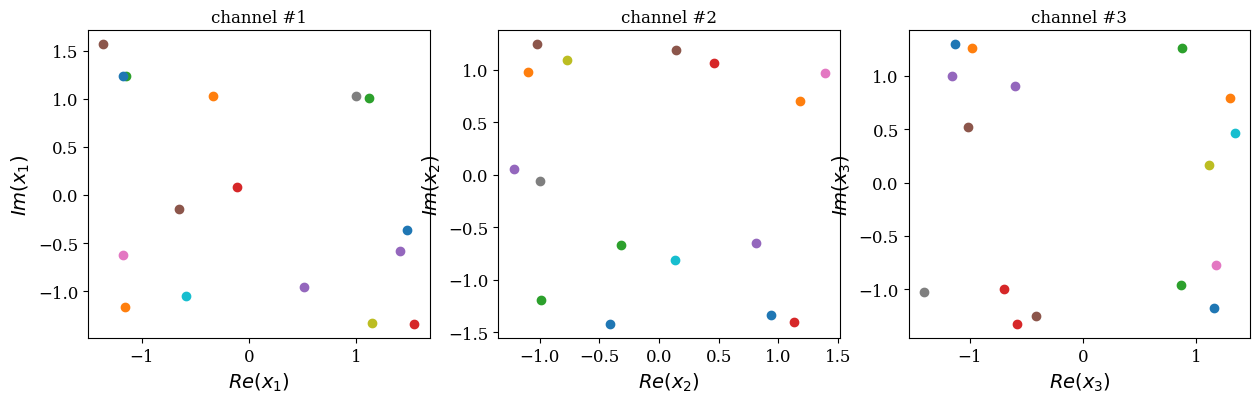

In [21]:
if PLOT_FIGURES:
    Constellation_Enc(encoder, M)